In [2]:
import pandas as pd
import numpy as np
!pip install mne
import mne

from mne import Epochs, pick_types
from mne.preprocessing import ICA
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.decoding import UnsupervisedSpatialFilter
from mne.viz import plot_topomap


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\AarPi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
from datetime import datetime, timezone, timedelta
import pytz

Step 1. Load eeg data

Creating RawArray with float64 data, n_channels=23, n_times=504527
    Range : 0 ... 504526 =      0.000 ...  1978.533 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


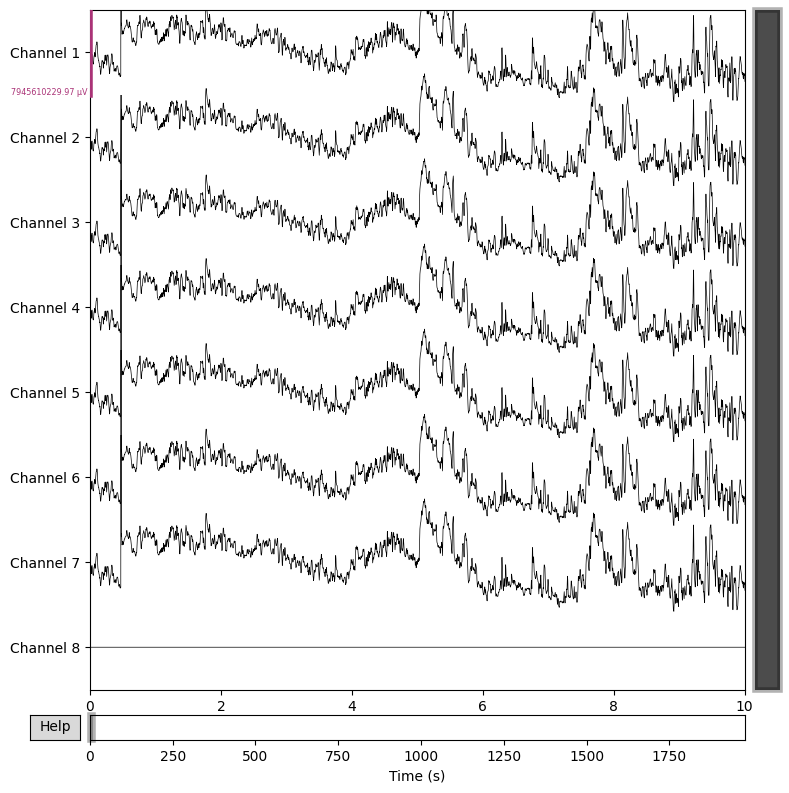

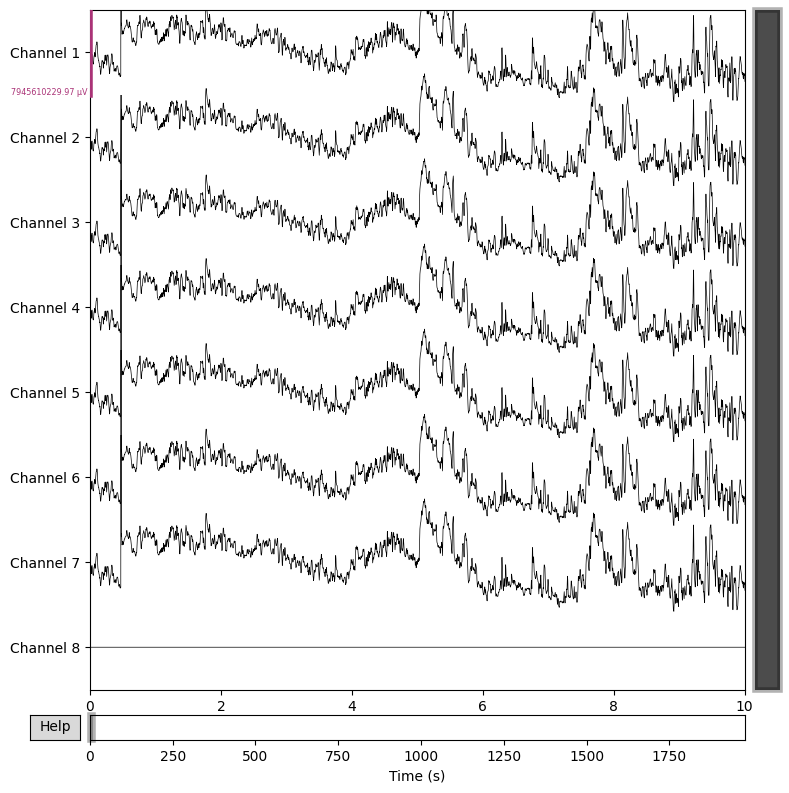

In [4]:
### Step 1. Load data ###                                      this is pretty much all from the workshop, except the meas_date stuff
# to load data using pandas
# file path to one csv file, merge csv files later?
eeg_file_path_csv = '../raw_EEG_data/BrainFlow-RAW_2025-02-23_14-24-48_1.csv'

#load csv into a pandas df
df = pd.read_csv(eeg_file_path_csv, sep='\t', skiprows=2, header=None)

#drop rows with missing values
df.fillna(0.0, inplace=True)

#extract eeg data
trial_data = df.iloc[:, 1:24].values

# Declares channel names and types of each set of data
sfreq = 255  # sample rate in Hz
ch_names = ['Channel {}'.format(i) for i in range(trial_data.shape[1])]
ch_types = ['eeg' for i in range(trial_data.shape[1])]

# unix data is in the 21st column

#function to convert a single unix value to utc
def unix_to_utc(unix_timestamp):
    utc_time = datetime.utcfromtimestamp(unix_timestamp).replace(tzinfo=timezone.utc)

    local_timezone = pytz.timezone('America/Los_Angeles')
    local_time = utc_time.astimezone(local_timezone)
    return utc_time

#the eeg start time is in the first row at the 21st column
eeg_start_time_unix = trial_data[0][21]

#meas_date requires start date in utc form so convert it using the function from before
meas_date = unix_to_utc(eeg_start_time_unix)

# Create info structures and RawArray objects for each set of data
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_meas_date(meas_date)                                              #setting meas_date
raw = mne.io.RawArray(trial_data.T, info)

# Removing irrelevant channels
ch_names = [raw.ch_names]
ch_names_to_keep = [ch_names[0][1:9]]
raw = raw.pick_channels(ch_names_to_keep[0])

# Now you can work with the MNE Raw object
# print(raw.info)
# print(raw.get_data())

# # Plot the specified interval
raw.plot(scalings='auto')


Add annotations to the data
Annotations simply mark when in the data a certain event happened. So we need to mark when certain things of interest happen in the data. This is an essential part for epoching and machine learning.
Use the log file or/and the csv file to determine when certain things showed up on screen.
- the log file may not be great for this, it seems to mark when things happned *in code* not necessarily when they were *displayed* 

In [5]:
#read in psychopy data
psyhcopy_file_path_csv = '../raw_PsychoPy_data/123_finaltest_2025-02-23_14h57.40.473.csv'

psychopy_df = pd.read_csv(psyhcopy_file_path_csv, delimiter=',', skiprows=0, header=0)

#converts psychopy form to unix
def psychopy_to_unix(psychopy_time):
    # Define the format of the input timestamp
    format_string = "%Y-%m-%d %Hh%M.%S.%f %z"

    # Parse the custom timestamp into a datetime object
    parsed_timestamp = datetime.strptime(psychopy_time, format_string)

    # Convert the datetime object to a Unix timestamp (floating-point for microseconds)
    unix_timestamp = parsed_timestamp.timestamp()

    # Print the Unix timestamp
    return(unix_timestamp)

#create a new column for the unix time of psychopy stimuli
psychopy_df = psychopy_df.dropna(subset=["expStart"])
psychopy_df["expStart"] = psychopy_df["expStart"].astype(str)
psychopy_df["unix_time"] = psychopy_df["expStart"].apply(psychopy_to_unix)

#make sure it worked
psychopy_df.head()


,symbols,amharic_set1,words_set1,amharic_set2,words_set2,amharic_set3,words_set3,amharic_set4,words_set4,amharic_practices,...,text_6.started,participant,session,date,expName,psychopyVersion,frameRate,expStart,Unnamed: 494,unix_time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09
1,✓,ቮ,cats,ኈ,fishing,ሐ,go,ና,dance,፨,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09
2,✗,ተ,north,ኴ,book,ሜ,artist,ኞ,education,፻,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09
3,NaN,ቺ,map,ዄ,mirror,ሣ,ring,ኧ,smart,ቇ,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09
4,NaN,ኇ,travel,ጕ,happy,ሯ,downtown,ኬ,late,ሏ,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09


In [6]:
import re

In [9]:
# read in the log file. this file is very useful for identifying when certain things in the code hapened but the csv should also be looked at
# and at what second relative to when the experiment started 

#load in the data
log_path = "../raw_PsychoPy_data/123_finaltest_2025-02-23_14h57.40.473.log"
log_df = pd.read_csv(log_path, sep="\t", header=None, encoding="utf-8")

#rename columns to make it easier to understand
log_df = log_df.rename(columns={0: "time", 1: "type", 2: "action"})

#drop the type column, it doesn't really matter
log_df = log_df.drop(columns=["type"])

# notice it doesn't start at 0, this is because these actions happen BEFORE the experiment starts. i.e. necessary background operations
log_df.head()


,time,action
0,79.4249,Loaded monitor calibration from ['2025_02_20 1...
1,79.4473,User requested fullscreen with size [1024 768...
2,83.9501,"Created window1 = Window(allowGUI=False, allow..."
3,83.9503,window1: backgroundImage = ''
4,83.9503,window1: backgroundFit = 'none'


In [10]:
# filter out log_df to get symbol_real_answer

# list of substrings to look for
substrings = ["textAmharic_5: autoDraw = True", "textAmharic_9: autoDraw = True", "textAmharic_6: autoDraw = True", 
              "textAmharic_7: autoDraw = True", "textAmharic_8: autoDraw = True", "textCheck: text = '✓'", "textXmark: text = '✗"]

#regex pattern
pattern = "|".join(substrings)   #this just says the patter we're looking for is "a or b or c or etc..."

key_log_df = log_df[log_df["action"].str.contains(pattern, na=False, regex=True)] #creating a sub dataframe based on filters

# autoDraw = True means something was drawn on screen, this has a corresponding time. textXmark or textCheck indicates that their response was either right or wrong
# I think this can be used to denote understood vs not understood symbols
# since there's 12 test questions you should see 12 rows of textAmharic_n. 
count = 1
key_log_df.iloc[24 * count: 24 * (count+1)]

# this is how much data we have for each participant in terms of blank n400 data, right AND wrong. 
# might be cause for concern
# print(len(key_log_df)/2)



,time,action
4106,601.8249,textAmharic_5: autoDraw = True
4126,607.2357,textCheck: text = '✓'
4160,608.9552,textAmharic_5: autoDraw = True
4180,614.4032,textCheck: text = '✓'
4214,615.9539,textAmharic_5: autoDraw = True
4234,620.8694,textCheck: text = '✓'
4266,622.3967,textAmharic_5: autoDraw = True
4286,627.5745,textCheck: text = '✓'
4320,629.0980,textAmharic_5: autoDraw = True
4340,634.6041,textCheck: text = '✓'


In [ ]:
#TO DO
# make a list of onsets
# list of durations
# tags for all of them
#    potential tags:
#       for test phases: 
#         ->  symbol_blank: when symbol first comes on screen, right vs wrong*
#         ->  symbol_real_answer: when the real answer appears on screen
#         ->  symbol_fake_answer: when the incorrect answers appear
#             wrong_button: when the participant selects the wrong wrong_button
#             correct_button: when the particpant selects the right wrong_button
# ->: these are the most important ones 
# *a challenge for this is going to be identifying symbol_blank that led to right answers vs wrong ones
#      need to make this distinction because this the N400 should only be present for right answers


###  1. make a list of onsets   ####
#  make a list for each tag, where the list is comprised of the time at which they showed up


# flatten them into one



### 2. list of durations ###
# is this necessary? if we epoch them around each annotations do 
# we even have to do this?



### 3. tags for all of them ###
# critical that the amount of tags line up with the length of each respective tag 
# in step one

,0,1,2
0,79.4249,INFO,Loaded monitor calibration from ['2025_02_20 1...
1,79.4473,WARNING,User requested fullscreen with size [1024 768...
2,83.9501,EXP,"Created window1 = Window(allowGUI=False, allow..."
3,83.9503,EXP,window1: backgroundImage = ''
4,83.9503,EXP,window1: backgroundFit = 'none'


In [11]:
#format of time in the psychopy csv file
time_format = "%Y-%m-%d %H:%M:%S.%f"

#new_orig_time = when psychopy started after the openbci

#create a buffer for when psychopy started after openbci
buffer = psychopy_df.loc[0, 'unix_time'] - eeg_start_time_unix

print(eeg_start_time_unix)
print(psychopy_df.loc[0, 'unix_time'])
print(buffer)

new_orig_time = (meas_date + timedelta(seconds=buffer)).strftime(time_format)

print(new_orig_time) 

later_annot = mne.Annotations(
    onset=[3.0, 5, 7],                    #onset, in seconds, when stimuli was shown
    duration=[1, 0.5, 0.25],            #how long they lasted
    description=["DDD", "EEE", "FFF"],  #names for the stimuli
    orig_time=new_orig_time,            #syncing psychopy start time and openbci start time
)

raw2 = raw.copy().set_annotations(later_annot)
print(later_annot.onset)
print(raw2.annotations.onset)


1740351367.289244
1740351490.74149
123.45224595069885
2025-02-23 22:58:10.741490
[3. 5. 7.]
[126.452246 128.452246 130.452246]


EEG data time range: 0 to 1978.5333333333333 seconds
Annotations in raw2: <Annotations | 3 segments: DDD (1), EEE (1), FFF (1)>
Adjusted onsets: [126.452246 128.452246 130.452246]


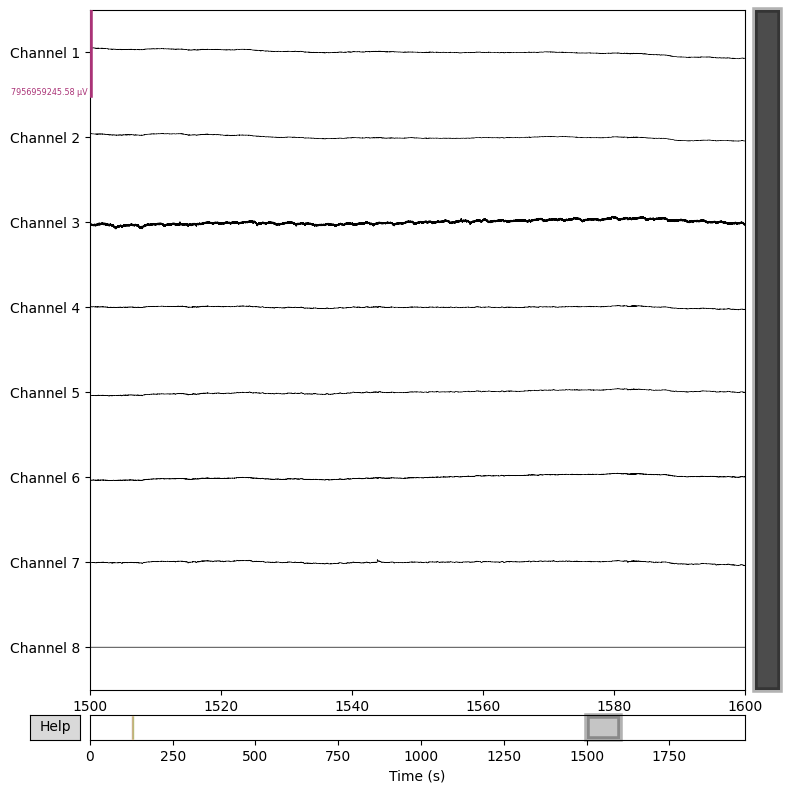

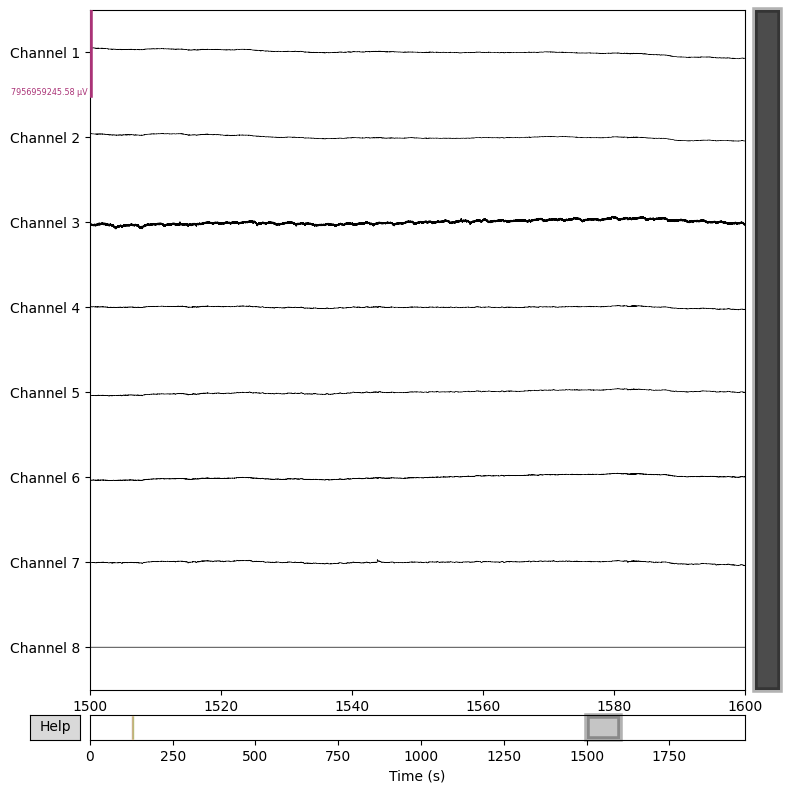

In [24]:
#debugging
print("EEG data time range: 0 to", raw.times[-1], "seconds")  #how long the experiment was in seconds
print("Annotations in raw2:", raw2.annotations)               #list of the annotations
print("Adjusted onsets:", raw2.annotations.onset)             #the adjusted onsets
raw2.plot(start=1500, duration=100, scalings='auto', block=True)  # Adjust start and duration as needed

Effective window size : 8.031 (s)


Plotting power spectral density (dB=True).


C:\Users\AarPi\AppData\Local\Temp\ipykernel_4076\128355210.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmin=0,fmax=50).plot()  #plot before filtering
C:\Users\AarPi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


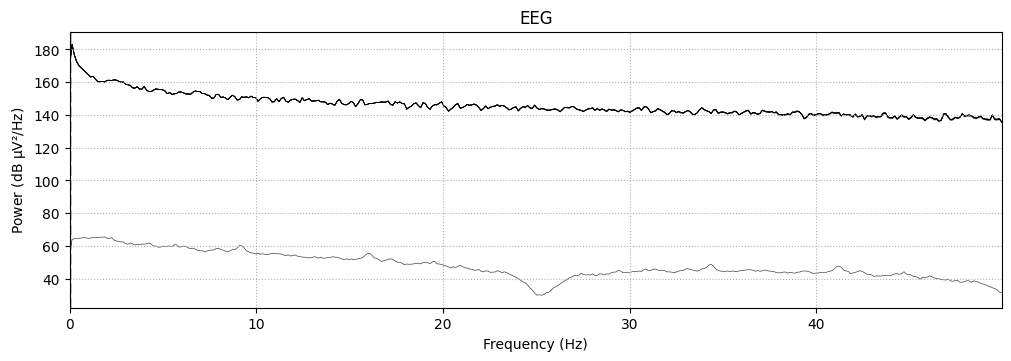

In [21]:
### Step 2. Filtering ####
raw.compute_psd(fmin=0,fmax=50).plot()  #plot before filtering


In [6]:
#setting high and low band pass filter
f_low = 0.1
f_high = 30
raw_cleaned = raw.filter(f_low, f_high, fir_design="firwin", skip_by_annotation="edge")   
#low and high pass filter, fir_design can be changed to match what lit review did

#notch filter for electrical noise
raw_cleaned.notch_filter(60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

<RawArray | 8 x 504527 (1978.5 s), ~30.8 MiB, data loaded>

Effective window size : 8.031 (s)
Plotting power spectral density (dB=True).


C:\Users\AarPi\AppData\Local\Temp\ipykernel_17524\2183862732.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_cleaned.compute_psd(fmin=0,fmax=50).plot()
C:\Users\AarPi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


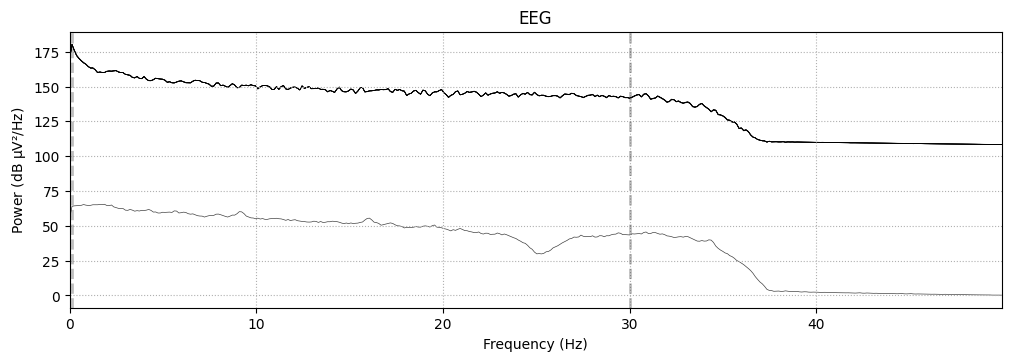

In [7]:
#new plot
raw_cleaned.compute_psd(fmin=0,fmax=50).plot()

In [8]:
### Selecting Non - Noisy Data
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")  
#pass in our raw file with all our eeg files
#exclude "bads" discards what signal are identified as bad. 
  #this does a lot of work for us

In [9]:
## ICA ##

#TO - DO: determine how many components there are, use 8 for now
ica = ICA(n_components=8, random_state=97, method="fastica")

ica.fit(raw_cleaned)   
#raw cleaned has been through filtering
#clean will have gone through ica

raw_clean = ica.apply(raw_cleaned)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


C:\Users\AarPi\AppData\Local\Temp\ipykernel_1264\2535494896.py:6: RuntimeWarning: Using n_components=8 (resulting in n_components_=8) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.9) and smallest (9.9e-14) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 4
  ica.fit(raw_cleaned)


In [ ]:
### Event based epoching ###
tmin, tmax = -0.2, 1
#this is a window of time around each event 

event_epochs = Epochs(
    raw_clean,                   # Variable that contains our data
    event_id=["hands", "feet"],  # Events we want to investigate, remember we changed T1 and T2 to this
    tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
    tmax=tmax,                   # End time relative to event
    proj=True,                   # Re-references data after everything we've done so far
    picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
    baseline=None,               # No baseline correction
    preload=True                 # Load the epochs into memory for faster access
)